## DR11 Sky-subtraction tests

In [1]:
import os, warnings
import numpy as np
import fitsio
import multiprocessing
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales as get_pixscale
from photutils.aperture import EllipticalAperture, aperture_photometry
from photutils.isophote import (EllipseGeometry, EllipseSample, Isophote, IsophoteList)

In [2]:
#datadir = '/pscratch/sd/d/dstn/dr11-sky/constant/'
datadir = '/pscratch/sd/d/dstn/dr11-sky/constant/coadd/184/1847p145'

In [3]:
bands = ['g', 'r', 'z']
refband = 'r'

#### SGA geometry for NGC 4254
https://www.legacysurvey.org/viewer-dev?ra=184.7061&dec=14.4169&layer=ls-dr9&zoom=13&sga

In [4]:
ra, dec = 184.706635, 14.416662
diam, ba, pa = 6.015 * 60., 0.93, 63. # diam in arcsec

#### Read the images and define the reference (r-band) image

In [5]:
jpg = mpimg.imread(os.path.join(datadir, f'legacysurvey-1847p145-image.jpg'))

reffile = os.path.join(datadir, f'legacysurvey-1847p145-image-{refband}.fits.fz')
hdr = fits.getheader(reffile, ext=1)
width = hdr['NAXIS1']
wcs = WCS(hdr)
pixscale = get_pixscale(wcs)[0] * width # [arcsec/pixel]

imgs = []
for band in bands:
    img = fitsio.read(os.path.join(datadir, f'legacysurvey-1847p145-image-{band}.fits.fz'))
    img /= pixscale**2 # [nanomaggies/arcsec2]
    if band == refband:
        refimg = img
    imgs.append(img)

#### Check the ellipse geometry

In [6]:
(x0, y0) = wcs.wcs_world2pix(ra, dec, 1)
semia = diam / 2. / pixscale # [pixels]
eps = 1. - ba
theta = np.radians(pa - 90.) # CCW from x-axis

(<matplotlib.patches.Ellipse at 0x7efe0bef2ef0>,)

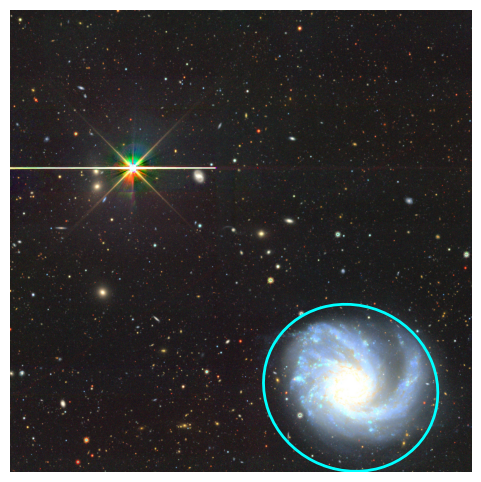

In [7]:
refgeo = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=semia, pa=theta)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.flipud(jpg), origin='lower', cmap='inferno')
ax.axis('off')
refap = EllipticalAperture((refgeo.x0, refgeo.y0), refgeo.sma,
                         refgeo.sma * (1. - refgeo.eps), refgeo.pa)
refap.plot(color='cyan', lw=2)

#### Derive the surface-brightness profile

In [8]:
def _integrate_isophot_one(args):
    """Wrapper function for the multiprocessing."""
    return integrate_isophot_one(*args)

In [9]:
def integrate_isophot_one(img, sma, theta, eps, x0, y0,
                          integrmode, sclip, nclip):
    """Integrate the ellipse profile at a single semi-major axis."""
    import copy
    g = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=sma, pa=theta)

    # Use the same integration mode and clipping parameters.
    # The central pixel is a special case:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if g.sma == 0.0:
            gcen = copy.deepcopy(g)
            gcen.sma = 0.0
            gcen.eps = 0.0
            gcen.pa = 0.0
            censamp = CentralEllipseSample(img, 0.0, geometry=gcen,
                                           integrmode=integrmode, sclip=sclip, nclip=nclip)
            out = CentralEllipseFitter(censamp).fit()
        else:
            sample = EllipseSample(img, sma=g.sma, geometry=g, integrmode=integrmode,
                                   sclip=sclip, nclip=nclip)
            sample.update(fixed_parameters=True)
            #print(filt, g.sma, sample.mean)

            # Create an Isophote instance with the sample.
            out = Isophote(sample, 0, True, 0)
    return out

In [10]:
def _unpack_isofit(isofit, filt):
    """Unpack the IsophotList objects into a dictionary."""
    COLS = ['sma', 'intens', 'intens_err', 'eps', 'eps_err',
            'pa', 'pa_err', 'x0', 'x0_err', 'y0', 'y0_err',
            'a3', 'a3_err', 'a4', 'a4_err', 'rms', 'pix_stddev',
            'stop_code', 'ndata', 'nflag', 'niter']
    DTYPES = [np.int16, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.int16, np.int16, np.int16, np.int16]
    
    I = np.isfinite(isofit.intens) * np.isfinite(isofit.int_err)    
    values = [isofit.sma[I], isofit.intens[I], isofit.int_err[I], isofit.eps[I], isofit.ellip_err[I],
              isofit.pa[I], isofit.pa_err[I], isofit.x0[I], isofit.x0_err[I], isofit.y0[I], isofit.y0_err[I],
              isofit.a3[I], isofit.a3_err[I], isofit.a4[I], isofit.a4_err[I], isofit.rms[I], isofit.pix_stddev[I],
              isofit.stop_code[I], isofit.ndata[I], isofit.nflag[I], isofit.niter[I]]
    data = {}
    for col, dtype, value in zip(COLS, DTYPES, values):
        data[f'{col}_{filt.lower()}'] = value.astype(dtype)
    return data

In [11]:
nsma = 32
smas = semia * np.linspace(0.01, 2.5, nsma) # aperture radii [pixels]

In [12]:
mp = 8
integrmode, sclip, nclip = 'median', 3, 3

data = {}
for band, img in zip(bands, imgs):
    print(f'Working on band {band}')
    with multiprocessing.Pool(mp) as P:
        iso = P.map(_integrate_isophot_one, [(img, sma, theta, eps, x0, y0,
                                              integrmode, sclip, nclip) for sma in smas])
    res = _unpack_isofit(IsophoteList(iso), band)
    data.update(res)
print(data.keys())

dict_keys(['sma_g', 'intens_g', 'intens_err_g', 'eps_g', 'eps_err_g', 'pa_g', 'pa_err_g', 'x0_g', 'x0_err_g', 'y0_g', 'y0_err_g', 'a3_g', 'a3_err_g', 'a4_g', 'a4_err_g', 'rms_g', 'pix_stddev_g', 'stop_code_g', 'ndata_g', 'nflag_g', 'niter_g', 'sma_r', 'intens_r', 'intens_err_r', 'eps_r', 'eps_err_r', 'pa_r', 'pa_err_r', 'x0_r', 'x0_err_r', 'y0_r', 'y0_err_r', 'a3_r', 'a3_err_r', 'a4_r', 'a4_err_r', 'rms_r', 'pix_stddev_r', 'stop_code_r', 'ndata_r', 'nflag_r', 'niter_r', 'sma_z', 'intens_z', 'intens_err_z', 'eps_z', 'eps_err_z', 'pa_z', 'pa_err_z', 'x0_z', 'x0_err_z', 'y0_z', 'y0_err_z', 'a3_z', 'a3_err_z', 'a4_z', 'a4_err_z', 'rms_z', 'pix_stddev_z', 'stop_code_z', 'ndata_z', 'nflag_z', 'niter_z'])


(<matplotlib.patches.Ellipse at 0x7efe0beaf100>,)

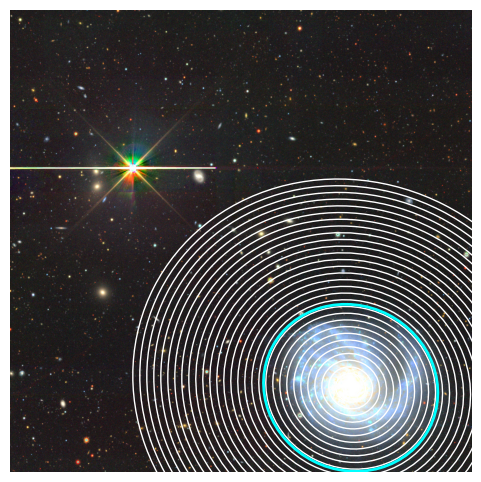

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.flipud(jpg), origin='lower', cmap='inferno')
ax.axis('off')
for sma in smas:
    g = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=sma, pa=theta)
    ap = EllipticalAperture((g.x0, g.y0), g.sma,
                         g.sma * (1. - g.eps), g.pa)
    ap.plot(color='white', lw=1)

refgeo = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=semia, pa=theta)
refap = EllipticalAperture((refgeo.x0, refgeo.y0), refgeo.sma,
                         refgeo.sma * (1. - refgeo.eps), refgeo.pa)
refap.plot(color='cyan', lw=2)    

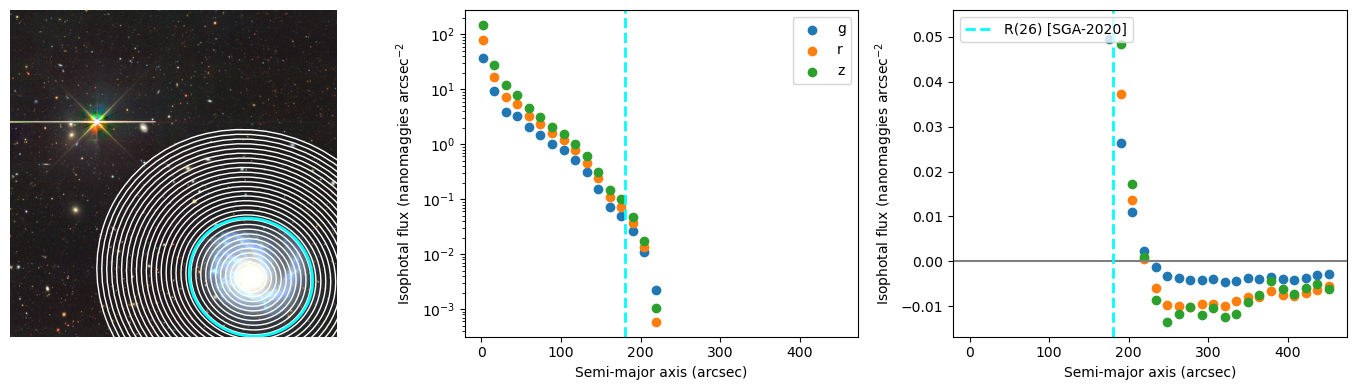

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.imshow(np.flipud(jpg), origin='lower', cmap='inferno')
ax1.axis('off')
for sma in smas:
    g = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=sma, pa=theta)
    ap = EllipticalAperture((g.x0, g.y0), g.sma,
                         g.sma * (1. - g.eps), g.pa)
    ap.plot(color='white', lw=1, ax=ax1)

refgeo = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=semia, pa=theta)
refap = EllipticalAperture((refgeo.x0, refgeo.y0), refgeo.sma,
                         refgeo.sma * (1. - refgeo.eps), refgeo.pa)
refap.plot(color='cyan', lw=2, ax=ax1)

for band in bands:
    ax2.scatter(pixscale*data[f'sma_{band}'], data[f'intens_{band}'], label=band)
ax2.set_yscale('log')
ax2.legend(loc='upper right')

for band in bands:
    ax3.scatter(pixscale*data[f'sma_{band}'], data[f'intens_{band}'])
ax3.axhline(y=0, color='gray')

last = np.abs(data[f'intens_{refband}'][-1])
ax3.set_ylim(-3*last, 10*last)

for xx in (ax2, ax3):
    xx.axvline(x=diam/2., color='cyan', lw=2, ls='--', label='R(26) [SGA-2020]')
    xx.set_xlabel('Semi-major axis (arcsec)')
    xx.set_ylabel(r'Isophotal flux (nanomaggies arcsec$^{-2}$')

ax3.legend(loc='upper left')
fig.tight_layout()